# Circuit Mechanisms for WM

## 1. Theoretical backgrounds

### Synaptic activity

**Continuous version**:

$$
\tau \dot{\mathbf{r}} = -\mathbf{r} + f \left( \mathbf{W}^{rec} \mathbf{r} + \mathbf{W}^{in} \mathbf{u} + \mathbf{b}^{rec} + \sqrt{2\tau \sigma^2_{rec}} \zeta \right)
$$

**Discrete version(Euler form)**:

$$
\mathbf{r}_t = (1 - \alpha) \mathbf{r}_{t-1} + \alpha f\left( \mathbf{W}^{rec} \mathbf{r}_{t-1} + \mathbf{W}^{in} \mathbf{u}_t + \mathbf{b}^{rec}  + \sqrt{\frac{2}{\alpha}} \sigma_{rec} N(0,1) \right)
$$

**Output**:

$$
z = g \left( \mathbf{W}^{out}\mathbf{r} + \mathbf{b}^{out} \right)
$$


where $\alpha := \Delta t / \tau$, $f(x) := max(0,x)$, $g(x_j) = \frac{\mathrm{exp}(x_j)}{\sum_i \mathrm{exp}(x_i) }$

### Synaptic efficacy (STSP)

**Mongillo(2008)**

$$
\begin{aligned}
\dot{x}(t) &=  \frac{1-x(t)}{\tau_D} - u(t) x(t) \delta(t-t_{sp}) \\[10pt]
\dot{u}(t) &=  \frac{U-u(t)}{\tau_F} - U(1-u(t)) \delta(t-t_{sp})
\end{aligned}
$$

**Masse(2019)**(Euler form)

$$
\begin{aligned}
\dot{x}(t) &=  \frac{1-x(t)}{\tau_x} - u(t) x(t) r(t) \\[10pt]
\dot{u}(t) &=  \frac{U-u(t)}{\tau_u} - U(1-u(t)) r(t)
\end{aligned}
$$

where $r(t)$: (pre-)synaptic activity

## 2. Implementations

### Import packages

In [1]:
# import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import pickle
import os
os.chdir("../../Short-term-plasticity-RNN/")

In [2]:
# import modules
import parameters 
import stimulus 
import model
import analysis
import simulate_STP

--> Loading parameters...
--> Parameters successfully loaded.

Using EI Network:	 True
Synaptic configuration:	 full 



### Parameters: parameters.py

In [3]:
par = parameters.par # define parameters

In [4]:
par['synapse_config'] = 'full'

In [5]:
model.print_important_params() # Print key parameters

num_iterations :  2000
learning_rate :  0.02
noise_rnn_sd :  0.5
noise_in_sd :  0.1
spike_cost :  0.02
spike_regularization :  L2
weight_cost :  0.0
test_cost_multiplier :  1.0
trial_type :  DMS
balance_EI :  True
dt :  10
delay_time :  1000
connection_prob :  1.0
synapse_config :  full
tau_slow :  1500
tau_fast :  200


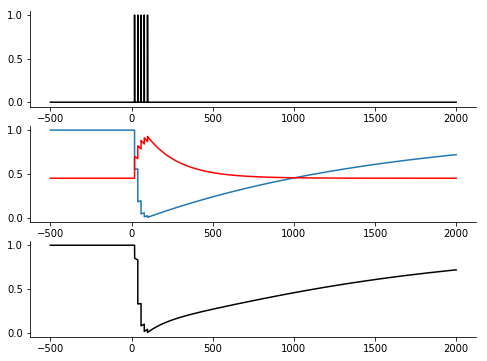

In [6]:
# simulate_STSP.py
simulate_STP.run_simulation()

### Train model: model.py

In [173]:
trial_info.keys()

dict_keys(['desired_output', 'train_mask', 'sample', 'test', 'rule', 'match', 'catch', 'probe', 'neural_input'])

In [7]:
stim = stimulus.Stimulus() # Create the stimulus class

In [8]:
# Create the stimulus class
m = tf.placeholder(tf.float32, [par['num_time_steps'], par['batch_size']], 'mask')
x = tf.placeholder(tf.float32, [par['num_time_steps'], par['batch_size'], par['n_input']], 'input')
t = tf.placeholder(tf.float32, [par['num_time_steps'], par['batch_size'], par['n_output']], 'target')

In [9]:
# Define model object
model_ = model.Model(x,t,m)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Start session
sess   = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
# keep track of the model performance across training
model_performance = {'accuracy': [], 'loss': [], 'perf_loss': [], 'spike_loss': [], \
            'weight_loss': [], 'iteration': []}

In [12]:
# Start iteration
for i in range(par['num_iterations']):

    # generate batch of batch_train_size
    trial_info = stim.generate_trial(set_rule = None)

    # Run the model
    _, loss, perf_loss, spike_loss, weight_loss, y, h, syn_x, syn_u = \
        sess.run([model_.train_op, model_.loss, model_.perf_loss, model_.spike_loss, \
        model_.weight_loss, model_.y, model_.h, model_.syn_x, model_.syn_u], 
        {x: trial_info['neural_input'], t: trial_info['desired_output'], m: trial_info['train_mask']})

    accuracy, _, _ = analysis.get_perf(trial_info['desired_output'], y, trial_info['train_mask'])
    model_performance = model.append_model_performance(model_performance, accuracy, loss, perf_loss, spike_loss, weight_loss, i)

    # Save the network model and output model performance to screen
    if i%par['iters_between_outputs']==0:
        model.print_results(i, perf_loss, spike_loss, weight_loss, h, accuracy)

# Save model and results
weights = sess.run(model_.var_dict)

DMS Iter.    0 | Accuracy 0.3438 | Perf loss 3.8499 | Spike loss 50.1977 | Weight loss 0.0977 | Mean activity 3.9766
DMS Iter.  100 | Accuracy 0.8670 | Perf loss 0.0565 | Spike loss 2.7406 | Weight loss 0.0908 | Mean activity 0.7196
DMS Iter.  200 | Accuracy 0.9528 | Perf loss 0.0222 | Spike loss 2.0621 | Weight loss 0.0993 | Mean activity 0.6030
DMS Iter.  300 | Accuracy 0.9650 | Perf loss 0.0170 | Spike loss 1.6939 | Weight loss 0.1058 | Mean activity 0.5302
DMS Iter.  400 | Accuracy 0.9733 | Perf loss 0.0139 | Spike loss 1.5495 | Weight loss 0.1118 | Mean activity 0.4959
DMS Iter.  500 | Accuracy 0.9743 | Perf loss 0.0128 | Spike loss 1.3939 | Weight loss 0.1190 | Mean activity 0.4629
DMS Iter.  600 | Accuracy 0.9829 | Perf loss 0.0082 | Spike loss 1.2899 | Weight loss 0.1260 | Mean activity 0.4382
DMS Iter.  700 | Accuracy 0.9849 | Perf loss 0.0077 | Spike loss 1.2346 | Weight loss 0.1344 | Mean activity 0.4205
DMS Iter.  800 | Accuracy 0.9852 | Perf loss 0.0076 | Spike loss 1.1900

In [37]:
# save model results
filename = "model_results_syn.pkl"
results = {'weights': weights, 'parameters': par}
for k,v in model_performance.items():
    results[k] = v
pickle.dump(results, open(filename, 'wb'))

In [29]:
# Loads the model weights and simulates the network on several different task conditions, saving the network activity and output
results = pickle.load(open(filename, 'rb'))
stim = stimulus.Stimulus()

In [ ]:
update_params = {
    'decode_stability':         False,
    'decoding_reps':            100,
    'simulation_reps':          100,
    'analyze_tuning':           True,
    'calculate_resp_matrix':    True,
    'suppress_analysis':        False,
    'decode_test':              False,
    'decode_rule':              False,
    'decode_match':             False,
    'svm_normalize':            True}

### analysis: analysis.py

+ Calculating behavioral accuracy without shuffling (shuffling left for future work)

In [40]:
# generate trials with match probability at 50%
trial_info = stim.generate_trial(test_mode = True)
input_data = np.squeeze(np.split(trial_info['neural_input'], par['num_time_steps'], axis=0))

h_init = results['weights']['h']

y, h, syn_x, syn_u = analysis.run_model(input_data, h_init, \
    results['parameters']['syn_x_init'], results['parameters']['syn_u_init'], results['weights'])

# generate trials with random sample and test stimuli, used for decoding
trial_info_decode = stim.generate_trial(test_mode = True)
input_data = np.squeeze(np.split(trial_info_decode['neural_input'], par['num_time_steps'], axis=0))
_, h_decode, syn_x_decode, syn_u_decode = analysis.run_model(input_data, h_init, \
    results['parameters']['syn_x_init'], results['parameters']['syn_u_init'], results['weights'])

In [41]:
# generate trials using DMS task, only used for measuring how neuronal and synaptic representations evolve in
# a standardized way, used for figure correlating persistent activity and manipulation
analysis.update_parameters({'trial_type': 'DMS'})
trial_info_dms = stim.generate_trial(test_mode = True)
input_data = np.squeeze(np.split(trial_info_dms['neural_input'], trial_info_dms['neural_input'].shape[0], axis=0))
_, h_dms, syn_x_dms, syn_u_dms = analysis.run_model(input_data, h_init, \
    results['parameters']['syn_x_init'], results['parameters']['syn_u_init'], results['weights'])
analysis.update_parameters(results['parameters']) # reset trial type to original value
analysis.update_parameters(update_params)

Updating parameters...
Updating parameters...
Updating parameters...


In [44]:
# calculate task accuracy
results['task_accuracy'],_,_ = analysis.get_perf(trial_info['desired_output'], y, trial_info['train_mask'])
results['task_accuracy_per_rule'] = []
for r in np.unique(trial_info['rule']):
    ind = np.where(trial_info['rule'] == r)[0]
    acc, _, _ = analysis.get_perf(trial_info['desired_output'][:,ind,:], y[:,ind,:], trial_info['train_mask'][:, ind])
    results['task_accuracy_per_rule'].append(acc)

print('Task accuracy',results['task_accuracy'])

Task accuracy 0.99144965


In [61]:
# Decode the sample direction from neuronal activity and synaptic efficacies using support vector machines
trial_time = np.arange(0,h.shape[0]*par['dt'], par['dt'])
trial_time_dms = np.arange(0,h_dms.shape[0]*par['dt'], par['dt'])
if par['decoding_reps'] > 0:
    print('decoding activity...')
    decoding_results = analysis.calculate_svms(h_decode, syn_x_decode, syn_u_decode, trial_info_decode, trial_time, \
        num_reps = par['decoding_reps'], num_reps_stability = 10, decode_test = par['decode_test'], \
        decode_rule = par['decode_rule'], decode_match = par['decode_match'])
    for key, val in decoding_results.items():
        if np.var(val) > 0:
            results[key] = val

    if par['trial_type'] in ['DMS', 'DMC', 'DMRS90', 'DMRS90ccw', 'DMRS45', 'DMRS180', 'location_DMS']:
        for key, val in decoding_results.items():
            if np.var(val) > 0:
                results[key + '_dms'] = val

    else:
        # Calculate decoding for a DMS trial, used to correlate persistent activity and manipulation
        analysis.update_parameters({'trial_type': 'DMS'})
        decoding_results = analysis.calculate_svms(h_dms, syn_x_dms, syn_u_dms, trial_info_dms, trial_time_dms, \
            num_reps = par['decoding_reps'], num_reps_stability = 0, decode_test = par['decode_test'], decode_rule = par['decode_rule'])
        for key, val in decoding_results.items():
            if np.var(val) > 0:
                results[key + '_dms'] = val
        analysis.update_parameters(results['parameters'])
        analysis.update_parameters(update_params)

decoding activity...
Only one unique rule; setting decode rule to False
Neuronal and synaptic delay period decoding 0.22868499 1.0


In [97]:
# Saving decoding info/results
decoding_infos = {'h': h_dms,
                  'syn_x':syn_x_dms,
                  'syn_u':syn_u_dms,
                  'trial_info':trial_info_dms}

pickle.dump(decoding_infos, open("decoding_infos.pkl", 'wb'))
decoding_infos_ = pickle.load(open("decoding_infos.pkl", 'rb'))

pickle.dump(decoding_results, open("decoding_res.pkl", 'wb'))
decoding_results_ = pickle.load(open("decoding_res.pkl", 'rb'))

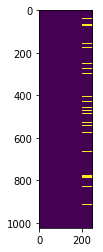

In [181]:
plt.imshow(trial_info['desired_output'][:,:,2].T)

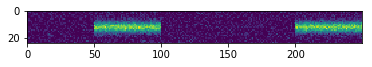

In [159]:
# Trial_neuronal input
plt.imshow(trial_info['neural_input'][:,601,:].T)
plt.show()

-0.030936401671305885


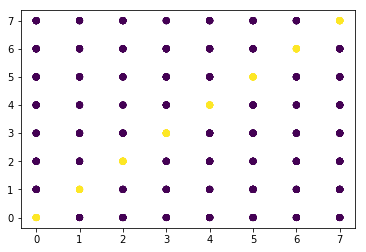

In [141]:
print(scipy.stats.pearsonr(trial_info['sample'], trial_info['test'])[0])
plt.scatter(trial_info['sample'], trial_info['test'], c=trial_info['match'])
plt.show()

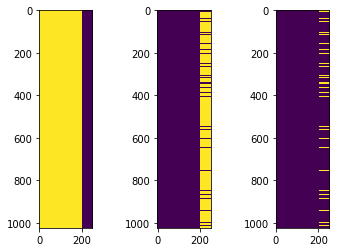

In [109]:
plt.subplot(1,3,1)
plt.imshow(decoding_infos['trial_info']['desired_output'][:,:,0].T)
plt.subplot(1,3,2)
plt.imshow(decoding_infos['trial_info']['desired_output'][:,:,1].T)
plt.subplot(1,3,3)
plt.imshow(decoding_infos['trial_info']['desired_output'][:,:,2].T)
plt.show()

### Analysis results

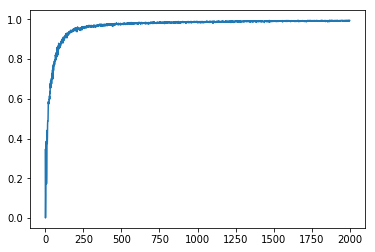

In [168]:
plt.plot(model_performance['iteration'],
         model_performance['accuracy'],)
plt.show()

In [137]:
print((trial_info['sample'] == trial_info['test'])[600])
print((trial_info['sample'] == trial_info['test'])[601])

False
True


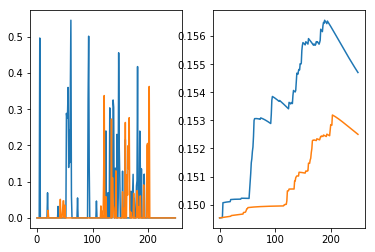

In [138]:
plt.subplot(1,2,1)
plt.plot(range(250), h_dms[:,600,30]) # 601th trial, 30th neuron 
plt.plot(range(250), h_dms[:,601,30]) # 602th trial, 30th neuron 
plt.subplot(1,2,2)
plt.plot(range(250), (syn_x_dms*syn_u_dms)[:,600,30])
plt.plot(range(250), (syn_x_dms*syn_u_dms)[:,601,30])
plt.show()

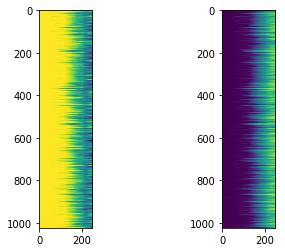

In [169]:
plt.subplot(1,2,1)
plt.imshow(syn_x_dms[:,:,80].T)
plt.subplot(1,2,2)
plt.imshow(syn_u_dms[:,:,80].T)
plt.show()

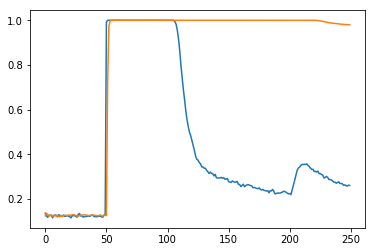

In [164]:
neu_sam_dc = np.mean(decoding_results['neuronal_sample_decoding'][0,0,:,:], axis=0)
syn_sam_dc = np.mean(decoding_results['synaptic_sample_decoding'][0,0,:,:], axis=0)

plt.plot(range(250),neu_sam_dc)
plt.plot(range(250),syn_sam_dc)
plt.show()

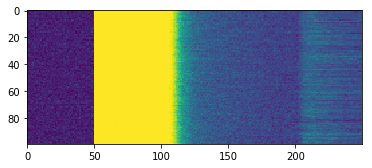

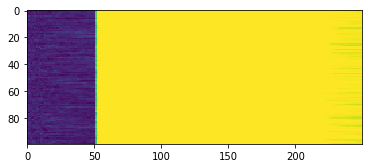

In [73]:
plt.imshow(decoding_results['neuronal_sample_decoding'][0,0,:,:])
plt.show()

plt.imshow(decoding_results['synaptic_sample_decoding'][0,0,:,:])
plt.show()

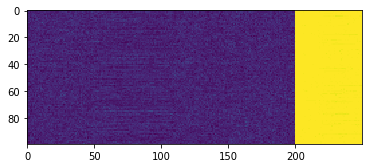

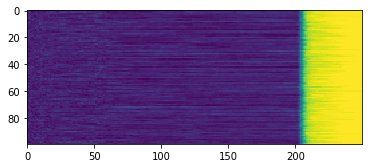

In [146]:
plt.imshow(decoding_results['neuronal_test_decoding'][0,0,:,:])
plt.show()

plt.imshow(decoding_results['synaptic_test_decoding'][0,0,:,:])
plt.show()

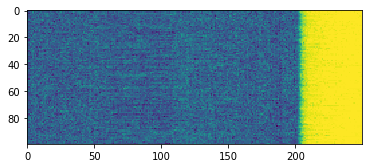

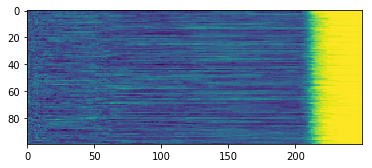

In [151]:
plt.imshow(decoding_results['neuronal_match_decoding'][0,0,:,:])
plt.show()

plt.imshow(decoding_results['synaptic_match_decoding'][0,0,:,:])
plt.show()

### Need more understanding...

#### 1. Stability

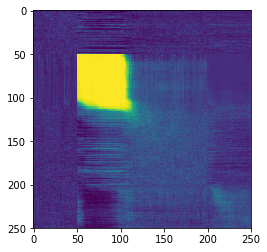

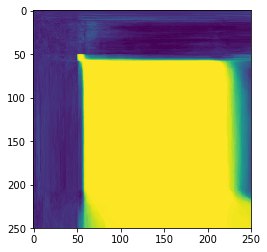

In [144]:
plt.imshow(decoding_results['neuronal_sample_decoding_stability'][0,0,5,:,:])
plt.show()

plt.imshow(decoding_results['synaptic_sample_decoding_stability'][0,0,5,:,:])
plt.show()

#### 2. Response matrix

In [51]:
print('calculate response matrix...')
resp_matrix_results = analysis.calculate_response_matrix(trial_info_decode, results['weights'])
for key, val in resp_matrix_results.items():
    if np.var(val) > 0:
        results[key] = val

calculate response matrix...


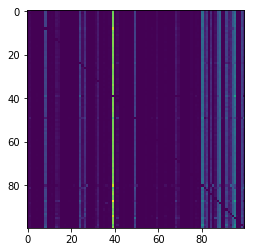

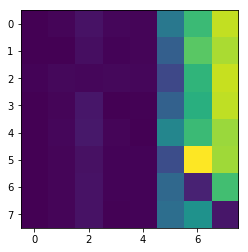

In [60]:
plt.imshow(resp_matrix_results['resp_suppresion'][:,:,0,0])
plt.show()

plt.imshow(resp_matrix_results['resp_no_suppresion'][20,:,:])
plt.show()

#### 3. Train mask

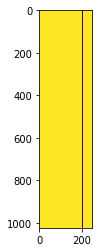

In [163]:
plt.imshow(trial_info['train_mask'].T)
plt.show()

## Future work

### 1) Shuffled network analysis

In [ ]:
# Calculate the neuronal and synaptic contributions towards solving the task
if par['simulation_reps'] > 0:
    print('simulating network...')
    simulation_results = analysis.simulate_network(trial_info, h, syn_x, \
        syn_u, results['weights'], num_reps = par['simulation_reps'])
    for key, val in simulation_results.items():
        if np.var(val) > 0:
            results[key] = val

### 2) PCA of RNN neuron activities

#### Michaelis et al.(2019) modular RNN

![](https://www.dropbox.com/s/mg8iarcvq9azlqd/Michaels%20et%20al%282019%29.png?dl=1)


#### Sohn et al.(2019) time-warping

![](https://www.dropbox.com/s/capithrnyirrajj/Sohn%20et%20al%282019%29.png?dl=1)